# Voice anonymization tutorial 🎤🎭

Our `fab` tool enables and facilitates some exciting things with voice analysis and processing. One of its tricks is to make someone's voice anonymous, like wearing a mask for your voice! 🎤🎭 One way to anonymize someone's voice is to make it sound similar to someone else's, just like a voice clone! And that's excactly what we are going to do in this tutorial. 

Following:
1. We'll download a dataset called "EmoDB." EmoDB has 535 voice recordings in German, spoken by 10 actors, each expressing 7 different emotions.

2. Next, through the `fab`'s `voice_anonymization` interface, we'll use a state-of-the-art tool called `coqui` to work its magic and anonymize the audio recordings. It's like a friendly assistant who will help us create those voice masks.

3. But, wait, we don't want to leave you hanging without knowing how good our voice masks are, right? So, we'll test them using something called a "speaker verification system." This system can tell how similar two voices are. We'll use a cool metric called "Equal Error Rate" (EER) to measure the performance of our voice masks.

So, get ready for a fun journey into the world of voice magic! Abracadabra! 🎩🎤🎭

### Setting up some libraries, params, and utility variables

Before proceeding, we have to define the necessary variables such as `dataset_url`, `data_folder`, and `dataset_name`. These variables will guide us to the EmoDB dataset's web address, determine where to store the data, and name the downloaded dataset. Also, the `anonymization_tool_name` will determine what anonymization tool we will use. Some anonymization tools, such as `coqui`, require also the `target_speakers_for_anonymization_folder` and the `target_speaker_for_anonymization_file` variables pointing at the folder and .wav file containing the voice we want to clone as a form of anonymization.

In [1]:
# This variable holds the web address from which we'll download the EmoDB dataset.
# It's like a treasure map guiding us to the wonderful voice recordings!
dataset_url = "http://emodb.bilderbar.info/download/download.zip"

# The data_folder variable points to the location where we'll store all the data and audio recordings.
# Think of it as our backstage area, well-organized and ready to showcase the talents of our voices!
data_folder = "./data/"

# The dataset_name variable will be the name we give to the EmoDB dataset once we download it.
# Just a friendly label to recognize it easily when we work with it later on.
dataset_name = "emodb_dataset"

# anonymization_tool_name holds the enchanting name of our magical tool, "coqui."
# "coqui" will help us weave the cloak of anonymity around the voices.
# It's like the sorcerer behind the voice masks!
anonymization_tool_name = "coqui"

# target_speakers_for_anonymization_folder represents the folder where we'll keep the chosen speakers.
# These speakers are ready to be anonymized, like a room filled with intriguing characters,
# waiting for their secret identities!
target_speakers_for_anonymization_folder = "target_speakers_for_anonymization/"

# The target_speaker_for_anonymization_file variable holds the file name of our protagonist.
# The brave "matt_male_adult_narakeet.wav" will undergo the voice anonymization process.
# We're about to witness a transformation like no other!
target_speaker_for_anonymization_file = "matt_male_adult_narakeet.wav"

In [3]:
# Let's import some essential libraries that will assist us in our voice anonymization journey.
import os
import pandas as pd
import numpy as np
import torchaudio
import torch
import sys
import pathlib
from speechbrain.utils.metric_stats import EER
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, Audio
import random
import logging

# tool_folder points to the path where we store all our magical tools, including the "voice_anonymization" interface.
# It's like the wizard's library, filled with powerful incantations!
tool_folder = "../../tools/"

# Now, we define the target folder and script directory paths for later use.
# The target_folder is where we'll store the audio representations.
target_folder = tool_folder + 'audio_representation'
script_directory = os.getcwd()
target_folder_absolute_path = os.path.join(script_directory, target_folder)

# We add the target_folder to the system path, so we can import the modules from there.
sys.path.insert(0, target_folder_absolute_path)

# Next, we import the AudioRepresentation class from the audio_representation module.
from audio_representation import AudioRepresentation

# Similarly, we set the path for the voice-anonymization tool folder for later use.
path_folder = tool_folder + 'voice-anonymization'
script_directory = os.getcwd()
path_folder_absolute_path = os.path.join(script_directory, path_folder)

# We add the path_folder to the system path to import modules from there as well.
sys.path.insert(0, path_folder_absolute_path)

# Now, let's import the VoiceAnonymizer class from the anonymizer module.
from anonymizer import VoiceAnonymizer

# Next, we start initializing some variables.
# target_speaker_file_path points to the audio file of our chosen speaker for anonymization.
target_speaker_file_path = data_folder + target_speakers_for_anonymization_folder + target_speaker_for_anonymization_file

# output_folder is where we'll save the output plots and results later on.
output_folder = data_folder + "output_plots/"

# We create the data_folder if it doesn't exist yet, to ensure we have a neat place to store data.
pathlib.Path(data_folder).mkdir(parents=True, exist_ok=True)

# dataset_path holds the path to our downloaded EmoDB dataset.
dataset_path = data_folder + dataset_name

# audio_folder_path points to the folder containing the original audio recordings in the EmoDB dataset.
audio_folder_path = dataset_path + "/wav/"

# anonymized_audio_folder_path is where we'll save the anonymized audio recordings.
# We'll create a new folder specific to the anonymization tool used for clarity.
anonymized_audio_folder_path = dataset_path + f"/anonymized_{anonymization_tool_name}_wav/"

# Finally, we set some environment variables, just to have them accessible throughout our code.
os.environ['dataset_url'] = dataset_url
os.environ['data_folder'] = data_folder
os.environ['dataset_name'] = dataset_name
os.environ['dataset_path'] = dataset_path

# Suppress debug messages
logging.getLogger('matplotlib.font_manager').disabled = True


### Setting up the dataset

Let's start by downloading the EmoDB dataset. 🎤📥

The following code will fetch the EmoDB dataset from the provided `dataset_url` and save it in the `data_folder`.

In [4]:
%%bash

# This bash script checks if the EmoDB dataset has already been downloaded.
# If the dataset folder exists, it means the dataset is already downloaded.
# Otherwise, it proceeds with the download process.

if [ -d "$dataset_path" ]; then
  # The dataset folder exists, so the dataset is already downloaded.
  echo "$dataset_name already downloaded in $dataset_path."
else
  # The dataset folder does not exist, indicating the dataset needs to be downloaded.
  echo "Downloading..."

  # Create the dataset folder and its parent directories, if they don't exist.
  mkdir -p "$dataset_path"

  # Use the 'wget' command to fetch the EmoDB dataset from the provided URL ($dataset_url).
  # Save the downloaded file as "$dataset_name.zip" in the "$dataset_path" folder.
  wget -O "$dataset_path"/"$dataset_name".zip "$dataset_url"

  # Unzip the downloaded dataset file ($dataset_name.zip) into the "$dataset_path" folder.
  # The '-d' option specifies the destination directory for the extracted files.
  unzip "$dataset_path"/"$dataset_name".zip -d "$dataset_path"

  # Remove the downloaded zip file, as we don't need it anymore.
  rm "$dataset_path"/"$dataset_name".zip
fi


DEBUG:asyncio:Using selector: KqueueSelector
emodb_dataset already downloaded in ./data/emodb_dataset.


Now that we've successfully downloaded the EmoDB dataset and have it at our disposal, it's time to embark on a delightful exploration of its voice recordings! 🎧🔍

What better way than by playing some random audio recordings from the dataset? 🌟🎭🔊


In [5]:
# This function, get_random_file_from_folder, takes a folder_path as input.
# It returns the name of a random file from the specified folder.

def get_random_file_from_folder(folder_path):
    # Use the os.listdir() function to obtain a list of all files in the folder_path.
    files = os.listdir(folder_path)

    # Randomly select a file from the list of files using random.choice().
    random_file = random.choice(files)

    # Return the name of the randomly selected file.
    return random_file

In [6]:
# We'll use the previously defined function, get_random_file_from_folder, to obtain a random audio file name.
# The function takes the audio_folder_path as input and returns the name of a random file from the folder.

random_original_file = get_random_file_from_folder(audio_folder_path)

# Now, we play the randomly selected audio file using the Audio() function.
# The Audio() function takes the complete path to the audio file as input.
# The path is created by concatenating the audio_folder_path and the randomly selected file name (random_original_file).

Audio(audio_folder_path + random_original_file)

### Anonymizing the voice in the dataset

Now comes the thrilling part of our voice anonymization adventure! We will use the powerful `coqui` voice cloning model to cloak the identities of the actors in the EmoDB dataset. 🎭🎤
The `coqui` model will weave its magic, replacing the original voices with our target voice, ensuring the true identities remain hidden. 
Prepare to be amazed as we unleash the `coqui` model to anonymize the voices, making each recording sound like our target speaker. The EmoDB dataset is about to undergo a magical transformation! 🧙‍♂️✨🎩

In [ ]:
# The following code plays the audio file of our chosen target speaker.
# The brave "matt_male_adult_narakeet.wav" will be anonymized with our coqui voice cloning.

# Using the Audio() function, we play the audio file located at the target_speaker_file_path.
# This will allow us to hear the original voice of our target speaker before the anonymization process.

Audio(target_speaker_file_path)

In [8]:
# The following function, anonymize_audio_files_in_folder, performs the magical voice anonymization process using the coqui voice cloning model.

def anonymize_audio_files_in_folder(tool_name, path_to_audio_folder, path_to_anonymized_audio_folder, target_speaker_file_path):
    # We start by initializing three empty lists to hold information about the audio files.
    source_files = []  # List to store paths of original audio files to be anonymized.
    target_files = []  # List to store paths of the synthetic target speaker's audio file.
    output_files = []  # List to store paths where the anonymized audio files will be saved.

    # Create a VoiceAnonymizer object, named anonymizer, which will perform the voice anonymization.
    anonymizer = VoiceAnonymizer()

    # Loop through all files in the specified audio folder (path_to_audio_folder).
    for file_name in os.listdir(path_to_audio_folder):
        # Check if the file has a ".wav" extension, indicating an audio file.
        if file_name.endswith(".wav"):
            # Obtain the full path of the audio file.
            file_path = os.path.join(path_to_audio_folder, file_name)

            # Create the corresponding path for the anonymized audio file.
            anonymized_file_path = file_path.replace(path_to_audio_folder, path_to_anonymized_audio_folder)

            # If the anonymized audio file doesn't exist, proceed with the anonymization process.
            if not os.path.exists(anonymized_file_path):
                # Create the necessary directories to store the anonymized audio file.
                pathlib.Path(os.path.dirname(anonymized_file_path)).mkdir(parents=True, exist_ok=True)

                # Add information about the audio files to their respective lists.
                source_files.append(file_path)  # Original audio file to be anonymized.
                target_files.append(target_speaker_file_path)  # Synthetic target speaker's audio file.
                output_files.append(anonymized_file_path)  # Path to save the anonymized audio file.

    # If there are audio files to be anonymized, call the anonymizer.anonymize() method.
    if len(source_files) > 0:
        anonymizer.anonymize(method=tool_name, source_files=source_files, target_files=target_files, output_files=output_files)

In [9]:
# The following code invokes the function anonymize_audio_files_in_folder to perform the voice anonymization.

# The function is called with the following arguments:
# - anonymization_tool_name: The name of the tool to use for anonymization (in this case, "coqui").
# - audio_folder_path: The path to the folder containing the original audio recordings in the EmoDB dataset.
# - anonymized_audio_folder_path: The path where the anonymized audio recordings will be saved.
# - target_speaker_file_path: The path to the audio file of our chosen target speaker ("matt_male_adult_narakeet.wav").

anonymize_audio_files_in_folder(anonymization_tool_name, audio_folder_path, anonymized_audio_folder_path, target_speaker_file_path)

The magic has taken place! Now, it's time to experience the captivating result of our voice anonymization adventure. 🎧🎭🔊
You can listen to the anonymized version of the previous audio recording. Is it good? Oh, indeed, it's more than good—it's absolutely mesmerizing! 🧙‍♂️🌟🔮

In [10]:
# The following code plays the anonymized audio version of a random audio file from the EmoDB dataset.

# Using the Audio() function, we play the anonymized audio file located at the specified path.
# The path to the anonymized audio file is created by concatenating the anonymized_audio_folder_path and the random_original_file.

Audio(anonymized_audio_folder_path + random_original_file)

### Evaluating voice anonymization based on the achieved privacy

Now comes the time to set a baseline for speaker verification on the orginal EmoDB dataset. To achieve this, we will employ the powerful Ecapa-TDNN model, which has been trained on the fascinating VoxCeleb dataset. 🧠🎙️ 

Here's what we'll do:

1. **Speaker Embeddings:** We'll use the Ecapa-TDNN model to extract unique speaker embeddings from the audio recordings. These embeddings allow for easy comparisons between speakers, like measuring the magical distance between them using cosine similarity.

2. **Distance Comparison:** By computing the cosine distance between pairs of original EmoDB audio recordings, we can determine how likely they come from different speakers. A larger distance suggests distinct speakers, while a smaller distance indicates similar voices.

In [11]:
# utilities

# The load_audio function loads an audio file using torchaudio and returns the waveform and sample rate.
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform

# Create an AudioRepresentation object, audio_repr, using the "EcapaTDNN" model.
audio_repr = AudioRepresentation(model_name="EcapaTDNN")

# The extract_embeddings function takes an input waveform and returns the corresponding speaker embeddings.
# It uses the audio_repr object to obtain the filtered_encoder_response for the input waveform.
def extract_embeddings(input_waveform):
    raw_encoder_response, filtered_encoder_response = audio_repr.contextual_encoding(input_waveform)
    return filtered_encoder_response

# The process_files_to_embeddings function processes all the audio files in a given folder to extract speaker embeddings.
# It loads the audio files, groups them by speaker, and then computes the speaker embeddings for each speaker group.
def process_files_to_embeddings(path_to_audio_folder):
    file_details = []
    for file_name in os.listdir(path_to_audio_folder):
        if file_name.endswith(".wav"):
            file_path = os.path.join(path_to_audio_folder, file_name)
            waveform = load_audio(file_path)
            speaker = file_name[:2]
            file_details.append([file_path, file_name, speaker, waveform.squeeze()])
    df = pd.DataFrame(file_details, columns=["Path", "Name", "Speaker", "Waveform"])
    df = pd.DataFrame(df.groupby('Speaker')['Waveform'].agg(lambda x: np.concatenate(x.values)), columns=['Waveform']).reset_index()
    all_embeddings = []
    for index, row in df.iterrows():
        waveform = row['Waveform']
        embeddings = extract_embeddings(torch.tensor(waveform))
        all_embeddings.append(embeddings.squeeze())
    df['Embeddings'] = all_embeddings
    return df

# The compute_similarity_score function computes the cosine similarity score between two speaker embeddings.
# It uses the torch.nn.CosineSimilarity to perform the cosine similarity computation.
def compute_similarity_score(embedding1, embedding2):
    cos = torch.nn.CosineSimilarity(dim=-1)
    similarity_score = cos(torch.tensor(embedding1), torch.tensor(embedding2))
    return similarity_score.item()

# The compute_eer_and_plot_verification_scores function compares embeddings and computes the Equal Error Rate (EER).
# It also creates a histogram plot with the verification scores.
def compute_eer_and_plot_verification_scores(df1, df2, label_df1, label_df2):
    df_rows = []
    for i, row1 in df1.iterrows():
        for j, row2 in df2.iterrows():
            s1 = row1['Speaker']
            s2 = row2['Speaker']
            e1 = row1['Embeddings']
            e2 = row2['Embeddings']
            cosine = compute_similarity_score(e1, e2)
            if s1 == s2:
                same = 1
            else:
                same = 0
            df_rows.append([s1, s2, e1, e2, cosine, same])

    df_pairs = pd.DataFrame(df_rows, columns=['Speaker 1', 'Speaker 2', 'Embeddings 1', 'Embeddings 2', 'Cosine distance', 'Same'])

    positive_scores = df_pairs.loc[df_pairs['Same'] == True]['Cosine distance'].values
    negative_scores = df_pairs.loc[df_pairs['Same'] == False]['Cosine distance'].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    plt.figure()
    ax = sns.histplot(df_pairs, x='Cosine distance', hue='Same', stat='percent', common_norm=False)
    ax.set_title(f'EER={round(eer, 4)} - Thresh={round(threshold, 4)}')
    plt.axvline(x=[threshold], color='red', ls='--')

    pathlib.Path(output_folder).mkdir(parents=True, exist_ok=True)
    plot_path = output_folder + f'EER_{label_df1}_{label_df2}.png'
    plt.savefig(plot_path, format='png')
    return plot_path

INFO:speechbrain.pretrained.fetching:Fetch hyperparams.yaml: Using existing file/symlink in /Users/fabiocat/Documents/git/fab/tools/audio_representation/tools/../pretrained_models/speechbrain_spkrec-ecapa-voxceleb/hyperparams.yaml.
INFO:speechbrain.pretrained.fetching:Fetch custom.py: Delegating to Huggingface hub, source speechbrain/spkrec-ecapa-voxceleb.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /speechbrain/spkrec-ecapa-voxceleb/resolve/main/custom.py HTTP/1.1" 404 0
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /Users/fabiocat/Documents/git/fab/tools/audio_representation/tools/../pretrained_models/speechbrain_spkrec-ecapa-voxceleb.
INFO:speechbrain.pretrained.fetching:Fetch embedding_model.ckpt: Using existing file/symlink in /Users/fabiocat/Documents/git/fab/tools/audio_representation/tools/../pretrained_models/speechbrain_spkrec-ecapa-voxceleb/embedding_model.ckpt.
INFO:speechbrain.pretrained.fetching:Fetch mean_v

In [12]:
# The following code processes the audio files in the specified audio_folder_path
# and extracts speaker embeddings for each speaker.

# Calling the process_files_to_embeddings function to obtain the DataFrame (df).
# This DataFrame (df) will contain the speaker embeddings for each speaker in the EmoDB dataset.
df = process_files_to_embeddings(audio_folder_path)

# The DataFrame (df) contains the following columns:
# - "Speaker": The unique identifier of the speaker.
# - "Waveform": Concatenated waveform of all audio recordings from the same speaker.
# - "Embeddings": Speaker embeddings extracted from the concatenated waveform.

# The DataFrame (df) holds the magical speaker embeddings, ready for our evaluation journey!
df

,Speaker,Waveform,Embeddings
0,03,"[-0.0035095215, -0.0034179688, -0.0035095215, ...","[tensor(15.4843), tensor(16.0624), tensor(22.2..."
1,08,"[0.0, 0.0, -3.0517578e-05, -3.0517578e-05, 0.0...","[tensor(-18.8081), tensor(-34.4952), tensor(-3..."
2,09,"[-0.002166748, -0.0019836426, -0.0012512207, -...","[tensor(20.8529), tensor(37.2469), tensor(5.14..."
3,10,"[0.0012207031, 0.0009765625, 0.0, 0.0, 0.00073...","[tensor(15.5112), tensor(2.7777), tensor(0.929..."
4,11,"[0.00036621094, -0.00036621094, -0.00036621094...","[tensor(33.6959), tensor(4.3437), tensor(34.80..."
5,12,"[0.0, -0.00021362305, -0.00045776367, 0.0, 0.0...","[tensor(33.4371), tensor(-14.1550), tensor(-0...."
6,13,"[0.0015869141, 0.00024414062, -0.0005187988, -...","[tensor(14.6202), tensor(22.2819), tensor(-17...."
7,14,"[0.0, 0.0, -3.0517578e-05, 9.1552734e-05, 0.0,...","[tensor(19.4504), tensor(41.1622), tensor(-1.1..."
8,15,"[-0.00045776367, -0.00045776367, -0.0004577636...","[tensor(13.0594), tensor(28.7624), tensor(23.9..."
9,16,"[0.0013122559, 0.00076293945, 0.00045776367, 0...","[tensor(-1.8589), tensor(33.8221), tensor(11.1..."


In [13]:
# The following code evaluates the Equal Error Rate (EER) for the original audio files,
# which means we are comparing each audio file to itself to see how similar they are.

# Calling the compute_eer_and_plot_verification_scores function with the DataFrame (df) as both input arguments.
# This function will compare the embeddings of each audio file to all other audio files in the DataFrame.
# The labels for the comparison will be set as "original" for both, as we are comparing the original audio files with themselves.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(df, df, "original", "original")

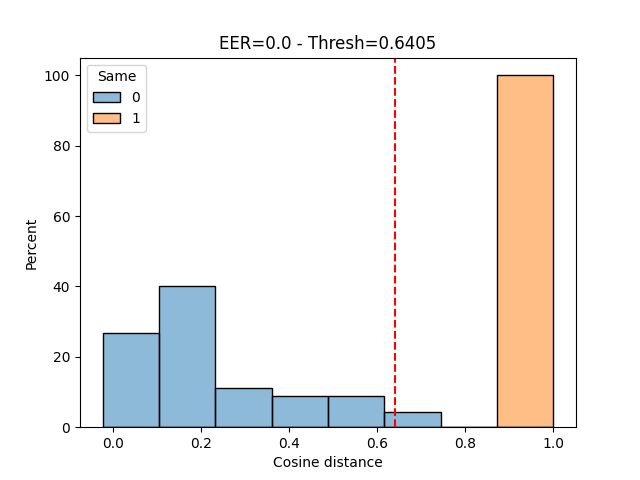

In [16]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison of audio files with themselves.
Image(filename=plot_path)

Now, we take our next step in the evaluation journey! We will extract the remarkable Ecapa-TDNN speaker embeddings from both the original audio recordings and the anonymized versions. 🎙️📏

Here's how we proceed:

1. **Anonymized Audio Embeddings:** First, we'll extract speaker embeddings from the anonymized audio clips.

2. **Distance Computation:** Finally, we'll compute the distances between pairs of original and anonymized audio clips. This will reveal the similarity between the original and disguised voices.


In [17]:
# The following code extracts Ecapa-TDNN speaker embeddings from the anonymized audio recordings
# and creates a DataFrame (anonymized_df) with the embeddings.

# Calling the process_files_to_embeddings function with the anonymized_audio_folder_path as input.
# This function will process the audio files in the anonymized_audio_folder_path and extract speaker embeddings for each speaker.
anonymized_df = process_files_to_embeddings(anonymized_audio_folder_path)

# The DataFrame (anonymized_df) contains the following columns:
# - "Speaker": The unique identifier of the speaker.
# - "Waveform": Concatenated waveform of all anonymized audio recordings from the same speaker.
# - "Embeddings": Speaker embeddings extracted from the concatenated anonymized waveform.

# The DataFrame (anonymized_df) now holds the magical speaker embeddings for the anonymized audio clips.
# We're ready to compare them with the embeddings from the original audio clips to measure the distance!
anonymized_df

,Speaker,Waveform,Embeddings
0,03,"[0.016662598, 0.016143799, 0.016662598, 0.0169...","[tensor(12.9128), tensor(-6.5728), tensor(-10...."
1,08,"[0.00289917, 0.0027770996, 0.0027160645, 0.002...","[tensor(19.9349), tensor(-3.8760), tensor(-9.1..."
2,09,"[0.0058898926, 0.005706787, 0.005493164, 0.005...","[tensor(13.2432), tensor(2.0174), tensor(-10.9..."
3,10,"[0.002960205, 0.0032043457, 0.0028686523, 0.00...","[tensor(7.6985), tensor(0.5945), tensor(-14.45..."
4,11,"[0.008758545, 0.0101623535, 0.010131836, 0.009...","[tensor(13.0266), tensor(-2.1572), tensor(-13...."
5,12,"[-0.0027770996, -0.0028076172, -0.0027770996, ...","[tensor(12.1726), tensor(-2.5535), tensor(-9.1..."
6,13,"[-0.0053100586, -0.005493164, -0.0056152344, -...","[tensor(14.2027), tensor(-1.7514), tensor(-14...."
7,14,"[0.001953125, 0.0018920898, 0.001739502, 0.001...","[tensor(16.2831), tensor(3.0656), tensor(-10.2..."
8,15,"[-0.00091552734, -0.00091552734, -0.0010681152...","[tensor(12.9088), tensor(1.0429), tensor(-11.8..."
9,16,"[0.0044555664, 0.0047912598, 0.004699707, 0.00...","[tensor(17.6592), tensor(-2.8987), tensor(-11...."


In [18]:
# The following code performs the Equal Error Rate (EER) computation
# between the embeddings of original and anonymized audio clips.

# Calling the compute_eer_and_plot_verification_scores function with two DataFrames, df and anonymized_df, as input arguments.
# The function will compare the embeddings of each audio file in df with all audio files in anonymized_df.
# We set the labels for the comparison as "original" for df and "anonymized" for anonymized_df.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(df, anonymized_df, "original", "anonymized")

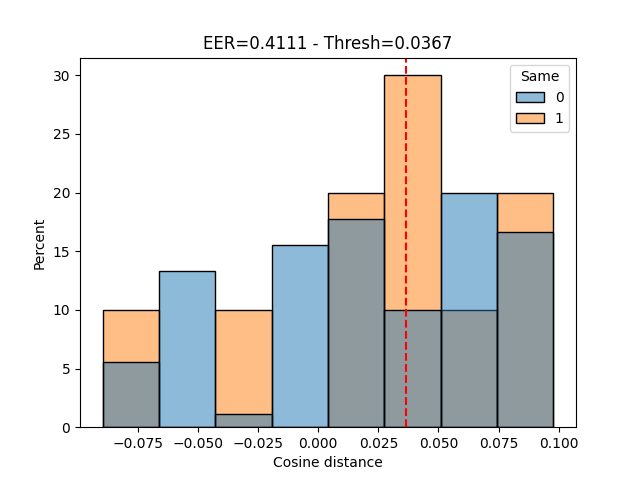

In [19]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison between original and anonymized audio clips.
Image(filename=plot_path)

Curiosity leads us to an intriguing exploration! Let's venture into the world of anonymized-anonymized pairs and unveil the mystery of similarity between them. 🤔🔍

Here's how we'll quench our curiosity:

1. **Anonymized-Anonymized Pairs:** We will compare the speaker embeddings of anonymized audio clips with one another. It's like peeking into the hidden world of disguised voices.

2. **Equal Error Rate (EER):** The EER will once again be our magical compass, guiding us to measure the similarity between these anonymous voices.

In [20]:
# The following code performs the Equal Error Rate (EER) computation
# between the embeddings of anonymized audio clips, comparing each anonymized clip to itself.

# Calling the compute_eer_and_plot_verification_scores function with the anonymized_df DataFrame as both input arguments.
# The function will compare the embeddings of each audio file in anonymized_df with all other audio files in anonymized_df.
# We set the labels for the comparison as "anonymized" for both, as we are comparing anonymized clips with themselves.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(anonymized_df, anonymized_df, "anonymized", "anonymized")

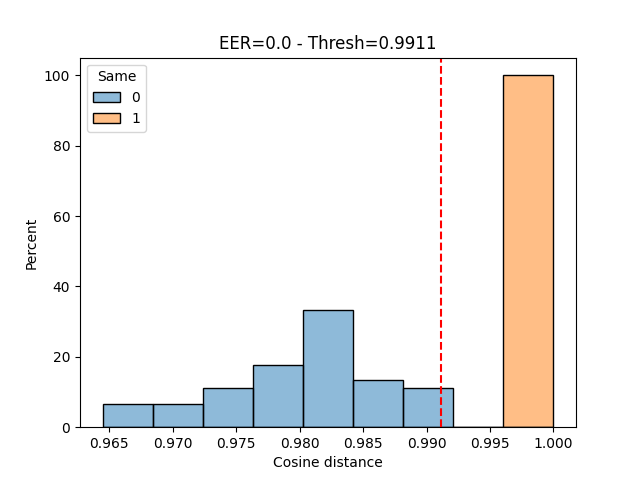

In [21]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison of anonymized audio clips with themselves.
Image(filename=plot_path)

### Conclusion

**Congratulations** on completing this voice anonymization tutorial! We hope you found it informative and enjoyable as we explored the fascinating world of concealing identities through technology. 

Remember, this tutorial serves as a starting point for your exploration. The realm of voice anonymization offers endless possibilities waiting to be uncovered and enhanced!

If you're interested in contributing to this tutorial and making it even better (somebody says it's an easy job), feel free to make a pull request with your valuable changes, ideas, or improvements. Together, we can create an enriching experience for future learners. 

## That's all, folks!